# Evaluation

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pitchscapes.plotting import set_axis_off, KeyEstimator, scape_plot_from_array, counts_to_colors

from rbnbase import RBNBase
from plotting import plot_series, scape_plot, plot_overview, plot_model_tree, plot_tree
from util import __TIME_SERIES__, pretty_print_chart, save_checkpoint
from evaluation import generate_data, train_CPD, train_RBN, evaluate
from loading import load_music
from plots import comparison

%load_ext autoreload
%autoreload 2

## Example

We start with the example given in Appendix B. The following defines a Gaussian RBN with $\mu_\mathrm{P}=0$, $\Sigma_\mathrm{P}=\Sigma_\mathrm{NL}=\Sigma_\mathrm{NR}=\Sigma_\mathrm{T}=1$ and $p_\mathrm{term}=1/2$ and computes the inside probabilities and marginal likelihood for the sequence $\mathbf{Y}=[0, 1, 2, 0]$.

In [2]:
data = torch.tensor([0, 1, 2, 0])
rbn = RBNBase(terminal_log_prob=np.log(0.5),  # p_term
              prior_mean=0,                   # \mu_P
              prior_sqrt_cov=1,               # \Sigma_P
              non_term_sqrt_cov=1,            # jointly sets \Sigma_{NL} and \Sigma_{NR}
#               left_non_term_sqrt_cov=None,  # only \Sigma_{NL}
#               right_non_term_sqrt_cov=None, # only \Sigma_{NR}
              term_trans_sqrt_cov=1,          # \Sigma_T
#               log_mixture_weights=(0.,),    # only one mixture component (no transpositions)
#               left_transpositions=(0,),     # no transpositions
#               right_transpositions=(0,),    # no transpositions
#               multi_terminal_lambda=None,   # no multi-terminal transitions
              reg=0.)                         # added to diagonals to avoid zero covariance during training (default 1e-4)
rbn.compute_inside(data)
print("Marginal Likelihood:", float(rbn.marginal_log_likelihood.exp()))

computing inside: 100%|██████████| 4/4 [00:00<00:00, 235.95it/s]

Marginal Likelihood: 4.6340330300154164e-05


This prints the parameters of the inside probabilities ($c_{i:k}^{(\beta)}$, $\mu_{i:k}^{(\beta)}$ and $\Sigma_{i:k}^{(\beta)}$) that are manually computed in Appendix B.

In [3]:
print("Inside coefficients")
pretty_print_chart(rbn.inside_log_coef, exp=True)
print("Inside means")
pretty_print_chart(rbn.inside_mean)
print("Inside variances")
pretty_print_chart(rbn.inside_cov)

Inside coefficients
                       ╱╲
                      ╱  ╲
                     ╱    ╲
                    ╱      ╲
                   ╱        ╲
                  ╱ 1.763e-04╲
                 ╱╲          ╱╲
                ╱  ╲        ╱  ╲
               ╱    ╲      ╱    ╲
              ╱      ╲    ╱      ╲
             ╱        ╲  ╱        ╲
            ╱ 1.657e-03╲╱ 1.582e-03╲
           ╱╲          ╱╲          ╱╲
          ╱  ╲        ╱  ╲        ╱  ╲
         ╱    ╲      ╱    ╲      ╱    ╲
        ╱      ╲    ╱      ╲    ╱      ╲
       ╱        ╲  ╱        ╲  ╱        ╲
      ╱ 2.200e-02╲╱ 2.200e-02╲╱ 1.512e-02╲
     ╱╲          ╱╲          ╱╲          ╱╲
    ╱  ╲        ╱  ╲        ╱  ╲        ╱  ╲
   ╱    ╲      ╱    ╲      ╱    ╲      ╱    ╲
  ╱      ╲    ╱      ╲    ╱      ╲    ╱      ╲
 ╱        ╲  ╱        ╲  ╱        ╲  ╱        ╲
╱    5.e-01╲╱    5.e-01╲╱    5.e-01╲╱    5.e-01╲
Inside means
                       ╱╲
                      ╱  ╲
              

This plots the data, the inside log-probabilities $\log c_{i:k}^{(\beta)}$ and the tree estimate.

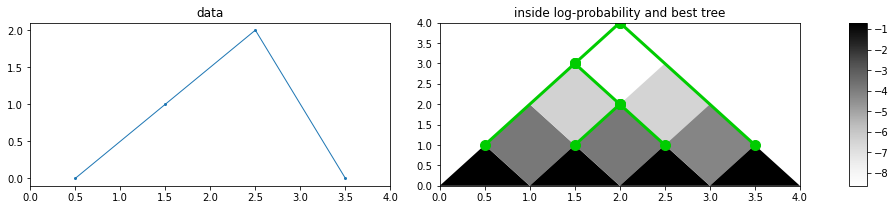

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw=dict(width_ratios=[1, 1, 0.05]))
plot_series(data,
            node_dict=rbn.max_tree()[0][0],
            separate=True,
            fig_ax=(fig, [axes[1], axes[0]]),
            tight_layout=False,
            tree_kwargs=dict(color=(0, .8, 0), lw=3,
                             inner_kwargs=dict(ms=10),
                             term_line_kwargs=dict(alpha=0.)))
scape_plot(rbn.inside_log_coef.arr.detach().numpy()[:, 0], ax=axes[1], cmap='Greys', colorbar=axes[2])
axes[1].set_title("inside log-probability and best tree")
axes[0].set_title("data");

It is interesting to see how minimal changes lead to a tie breaking in the tree estimate (reevaluate the previous cell to see the effect). This is even more interesting for longer sequences, which could be generated left-to-right or right-to-left. Here we can see the effect of competing tie breaks (observations that are slightly closer together than the others) that determine, which generation direction is more likely.

In [5]:
# data = torch.tensor([0, 0.999, 2, 0])                   # tie breaking towards grouping y_1 and y_2
# data = torch.tensor([0, 1.001, 2, 0])                   # tie breaking towards grouping y_2 and y_3
data = torch.tensor([0, 1.002, 2, 3, 4, 5, 6, 6.999, 0])  # competing tie breaks in longer sequence
rbn.compute_inside(data);

computing inside: 100%|██████████| 9/9 [00:00<00:00, 292.66it/s]


To get more detailed insights into the values computed during inference you can use this overview plot.

computing outside: 100%|██████████| 9/9 [00:00<00:00, 70.78it/s]


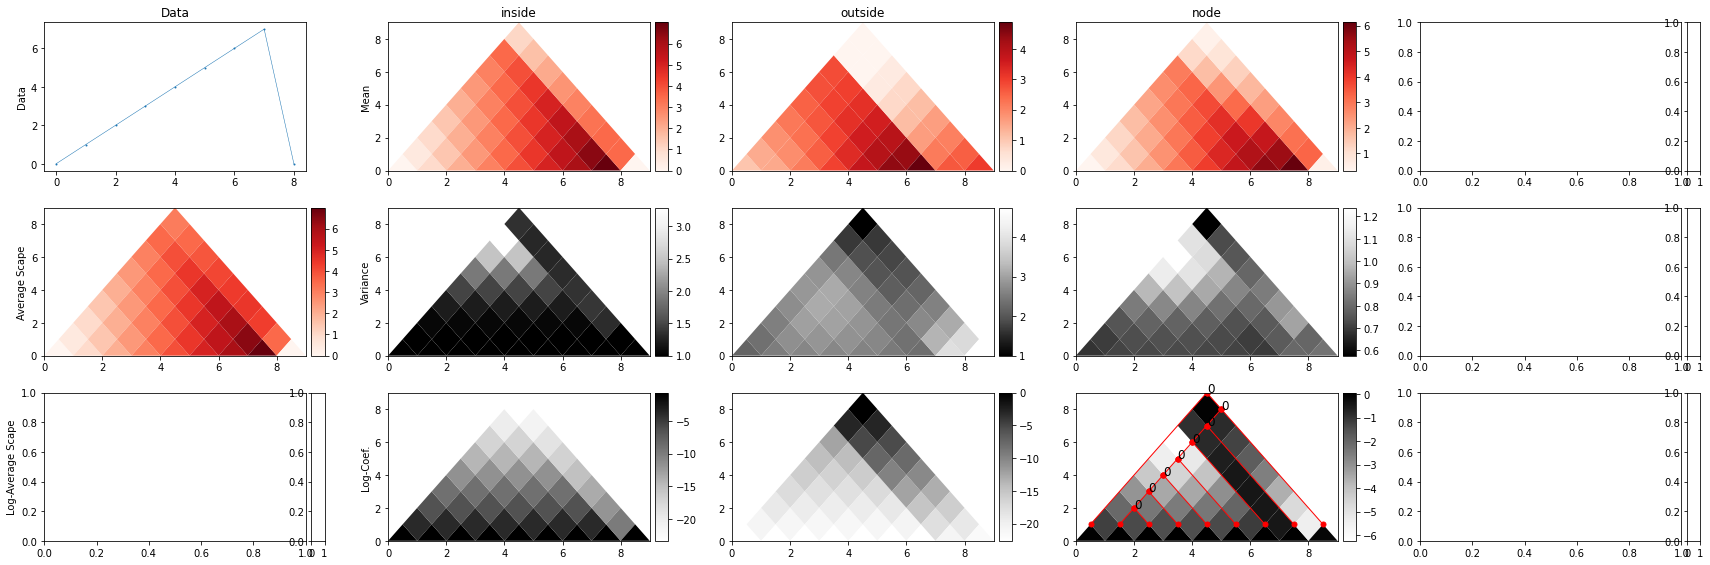

In [6]:
# first compute outside and marginal probabilities
rbn.compute_outside()
plot_overview(rbn=rbn,
              music_data=None,
              batch_idx=0,
              data_type=__TIME_SERIES__,
              plot_tree=True,
              log_scale=True)

## Quantitative Evaluation

### Generating Data

To generate datasets for the evaluation run the following command with `n_samples` specifying the numbe of sequences to be generated per noise level. The datasets are saved with a leading time stamp and relevant parameters in the file name.

We have included the data sets used for the evaluation in the paper. If you want to generate new datasets, you have to
1. run the cell with
    1. `n_samples=10` for RBN training data
    1. `n_samples=100` for CPD training data
    1. `n_samples=500` for validation data
1. delete or rename the existing datasets
1. remove the timestamp from the file names for further processing.

To have a look at the data (similar to Figure 8 in Appendix C but with out the results from the models), set `n_samples=1` and `plot_data=True`, which will generate **and visualise** one sequence for each noise level.

In [7]:
generate_data(plot_data=False, 
              n_samples=1)

100%|██████████| 6/6 [00:00<00:00,  9.02it/s]

writing data to 2021-11-02_10-35-59_data_l50_n1_m5.pkl ...
DONE


### Training the Baseline

Execute the following to perform a gridsearch over different search methods, cost functions, and penalty values of change-point detection methods in the `ruptures` library (Figure 9 in Appendix C). With `compute_results=True` all values will be recomputed, `compute_results=False` will attempt to load existing results (results from the paper are provided).

For a quick test, use `n_samples=1`, to reproduce results from the paper use `n_samples=100` (generating all plots may take a couple of minutes).

For values other than 1, 10, 100, 500 for `n_samples` you will need to generate you own datasets (see above).

100%|██████████| 600/600 [00:00<00:00, 132598.26it/s]


plotting results and saving to 2021-11-02_10-36-00_plot_CPD_tuning_l50_n100_m5.pdf ...
DONE


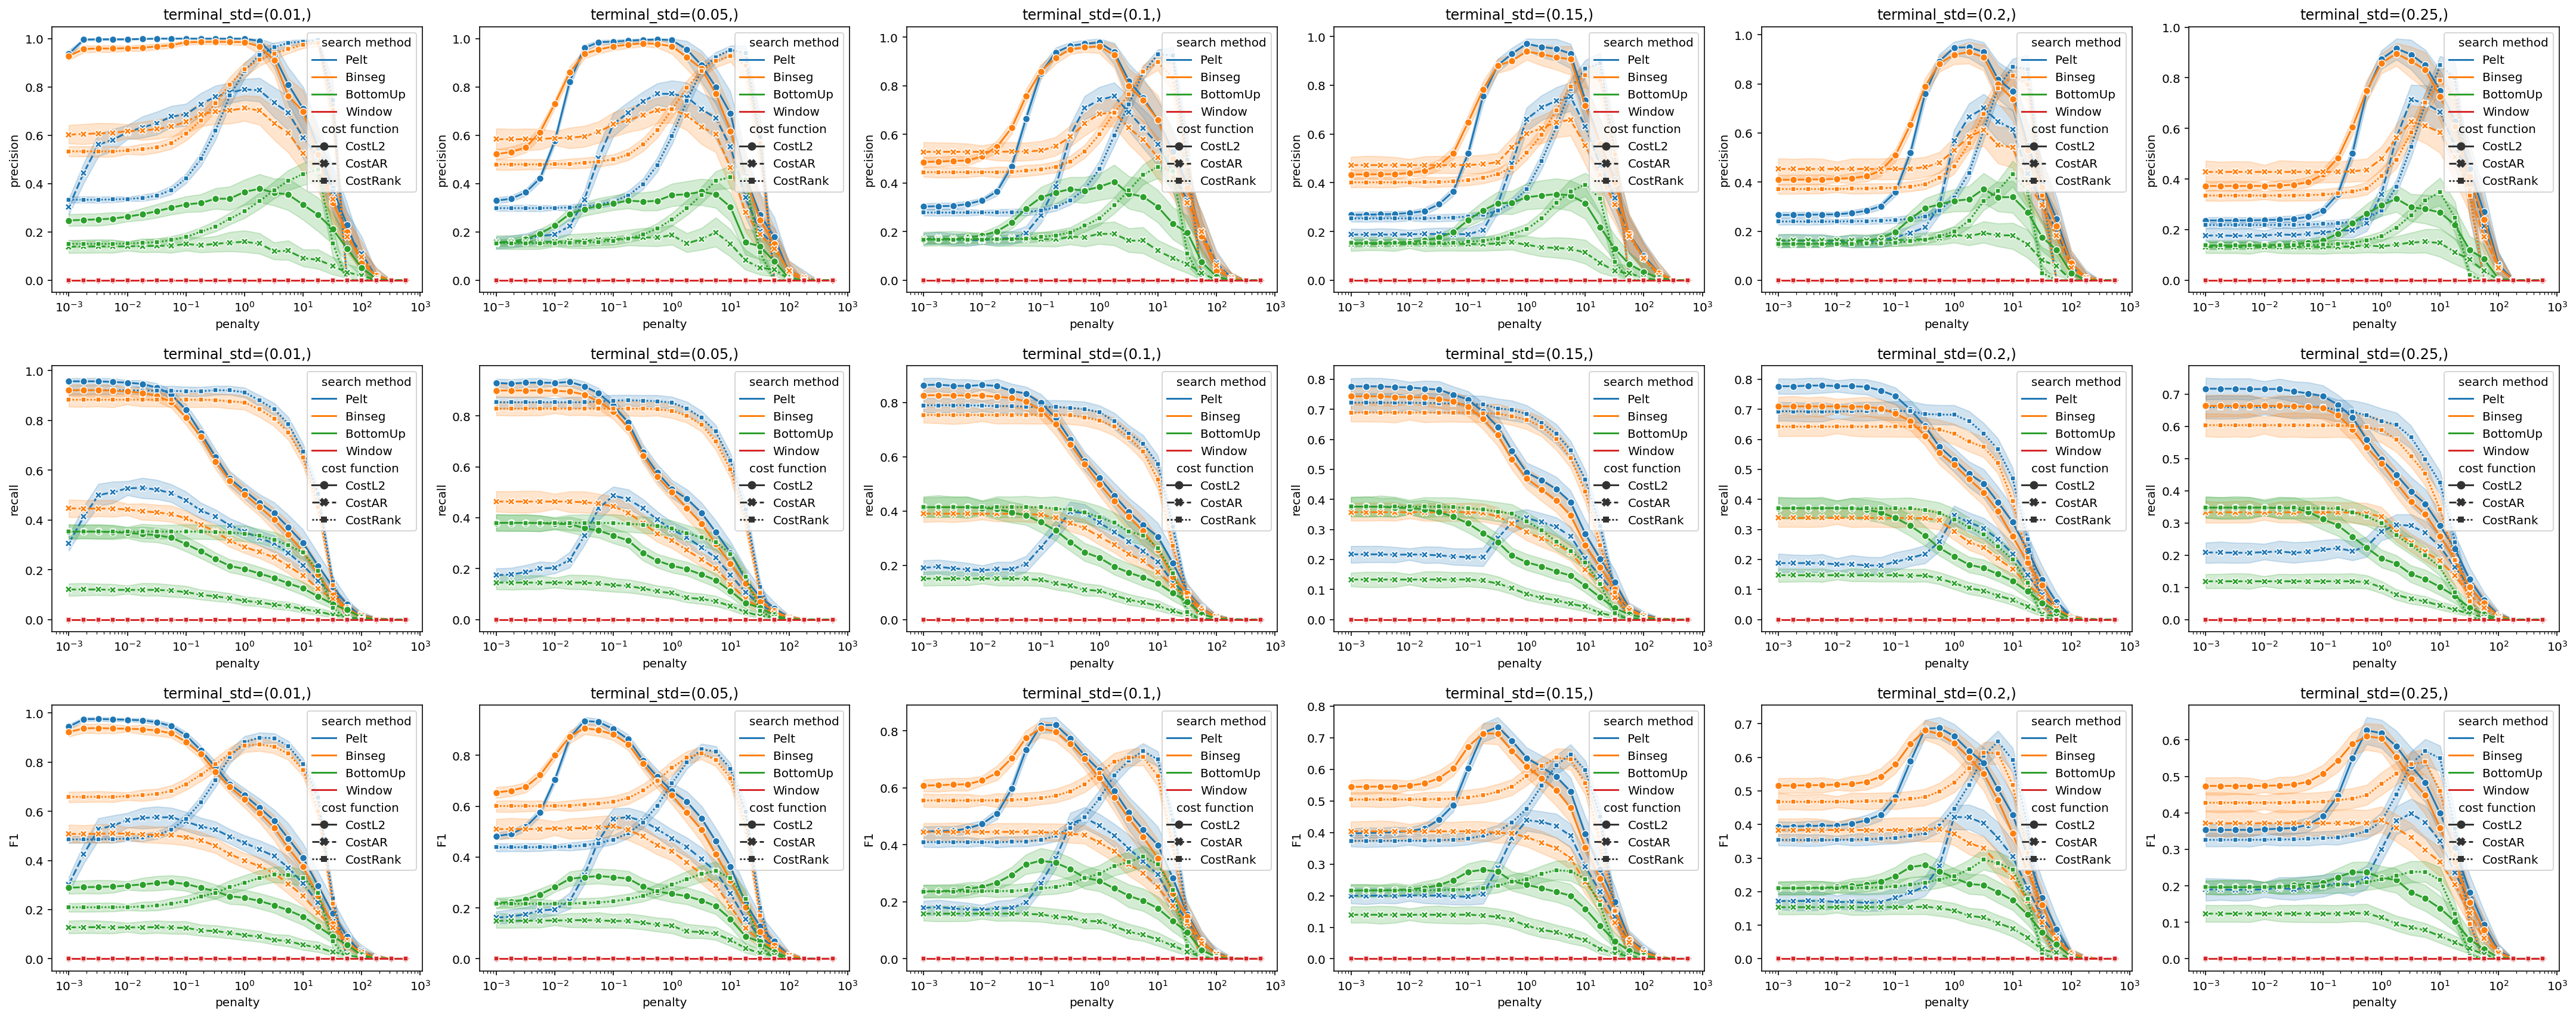

In [8]:
train_CPD(n_samples=100, compute_results=False)

### Training RBNs

The following trains an RBN from scratch on data with the given noise level `terminal_std` (this does not set the parameter of the trained model, but refers to the parameter used for generating the data). For a quick test use `n_samples=1`, to reproduce the results from the paper use `n_samples=10`.

The pretrained parameters used for the evaluation in the paper can be loaded by setting `pre_trained=True`.

In [9]:
# noise levels: 0.01, 0.05, 0.1, 0.15, 0.2, 0.25
train_RBN(terminal_std=0.01,    # noise level
          n_samples=1,          # number of sequences per noise level
          max_epochs=10,        # maximum number of epochs
          pre_trained=False,    # whether to load a model with pretrained parameters
          print_params=False,   # prints parameters after each epoch (otherwise only at the end)
          plot_progress=False   # plots loss per sequence over epochs after each epoch
         )

epoch 10: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it, average loss: 73.12874603271484]

terminal_std: 0.01
_prior_mean () torch.float32
    -0.022877130657434464
    --> prior_mean (3,)
        [-0.02287713 -0.02287713 -0.02287713]
_prior_sqrt_cov () torch.float32
    1.8996845483779907
    --> prior_cov (3, 3)
        [[3.6472905 0.        0.       ]
 [0.        3.6472905 0.       ]
 [0.        0.        3.6472905]]
terminal_log_prob (1,) torch.float32
    [-0.62956655]
_term_trans_sqrt_cov () torch.float32
    0.39744988083839417
    --> term_trans_cov (3, 3)
        [[0.166595 0.       0.      ]
 [0.       0.166595 0.      ]
 [0.       0.       0.166595]]
_non_term_sqrt_cov () torch.float32
    0.39606210589408875
    --> right_non_term_cov (3, 3)
        [[0.16562591 0.         0.        ]
 [0.         0.16562591 0.        ]
 [0.         0.         0.16562591]]
    --> left_non_term_cov (3, 3)
        [[0.16562591 0.         0.        ]
 [0.         0.16562591 0.        ]
 [0.         0.         0.16562591]]
    --> non_term_cov = None
_log_multi_terminal_lambda () to

### Validation and Comparison

This computes the precision, recall, and F1 measure for all models. Results can be recomputed or the provided results can be loaded. Use `n_samples=1` for a quick test and `n_samples=500` for reproducing the results from the paper (with `compute_cpd_results`, `compute_rbn_results` and `RBN_marginal=False` set to `True` – this will take a while).

results saved as 2021-11-02_10-38-22_plot_scores_l50_n500_m5.pdf


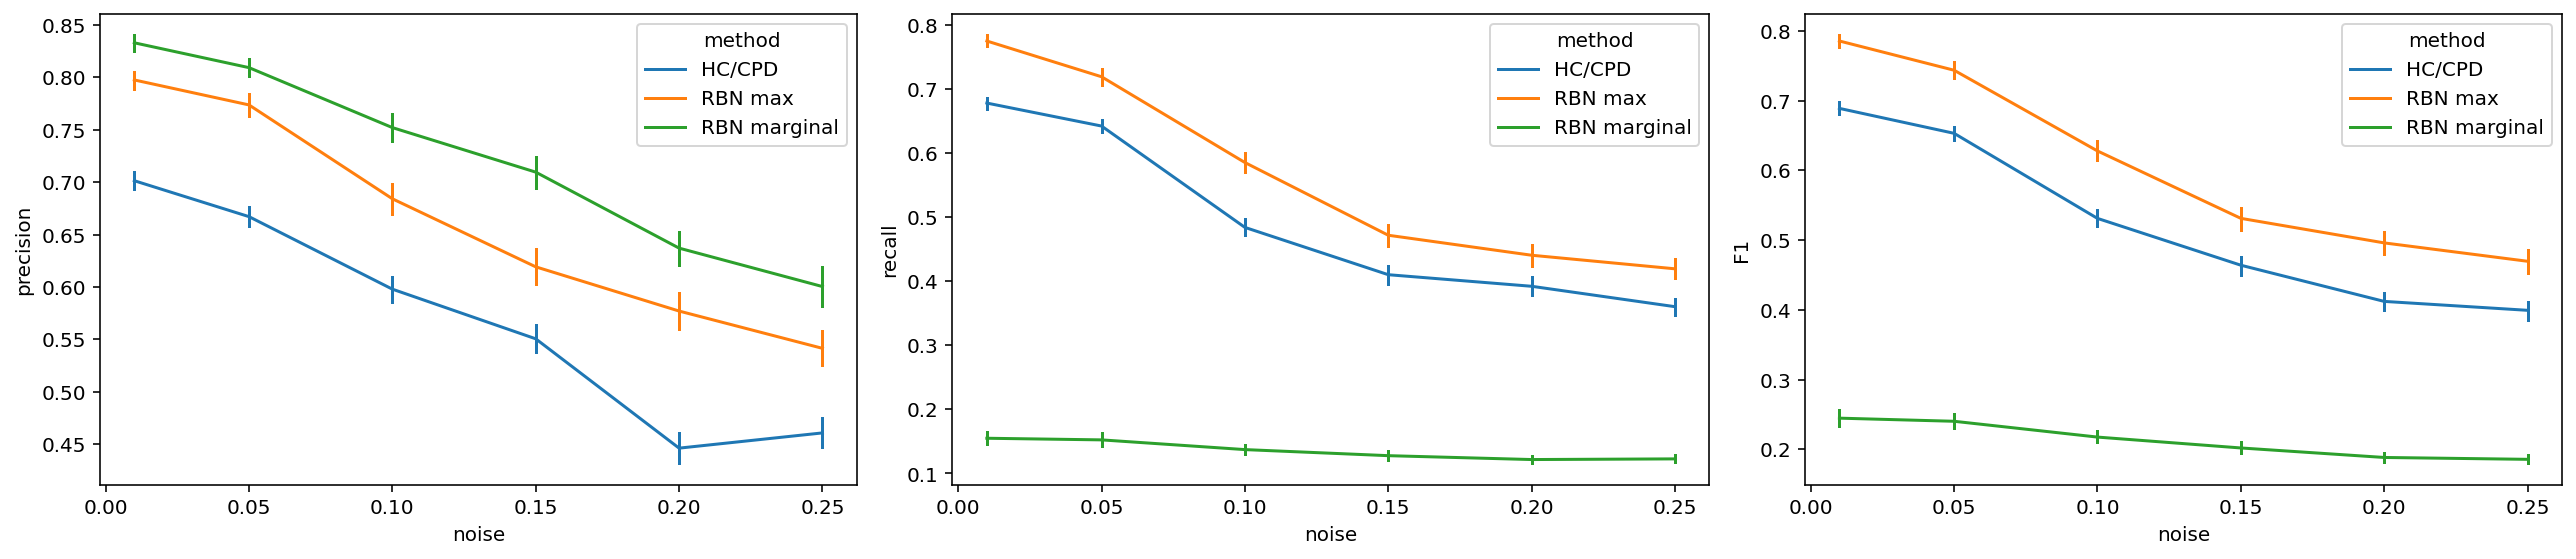

In [10]:
evaluate(n_samples=500,               # sequences per noise level
         compute_cpd_results=False,   # whether to recompute results for CPD/HC
         compute_rbn_results=False,   # whether to recompute results for RBN tree estimate (relatively quick)
         RBN_marginal=False,          # whether to recompute results for RBN marginal estimate (this can take a while)
         rbn_parallel=True,           # parallelise evaluation for RBNs
         plot_data=False,             # plot results for all (!!) sequences (like Figure 8 in Appendix C)
         n_data_points=None           # truncate the data set after the first number of points (e.g. for only plotting some results)
        )

## Hierarchical Music Analysis

### Training from Scratch

The following code can be used to train an RBN model from scratch on music data in MusicXML or MIDI format (or essentially any format that `music21` can read). `file_paths` specifies a list of file names to be loaded. Unfortunately, we are not allowed to distribute the electronic versions of the musical scores. But we provide the pre-trained model used in the paper (see below).

In [ ]:
data = load_music(n_samples=10,    # resolution for sampling the piece (use 70 for reproducing results from the paper)
                  file_paths=['./path/to/score.mxl'],
                  prior_counts=0,  # don't add prior counts to the pitch-class distributions
                  parallel=False)  # processing can be parallelised for a large number of files
observations = torch.from_numpy(data.observations)

# initialise RBN for training
rbn = RBNBase(terminal_log_prob=-0.66,
              trans_inv_prior=True,                                 # transposition invariant prior
              prior_mean=(0.1, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0, 0),  # \mu_P: initial bias towards the key of C (makes interpretation easier and avoids later transposing everything for plotting)
              prior_sqrt_cov=0.2,                                   # \Sigma_P
              non_term_sqrt_cov=0.2,                                # \Sigma_{NL} and \Sigma_{NR}
                                                                    # no terminal variance for categorical data
              log_prior_counts=np.log(0.01),                        # prior counts needed to deal with zero values in the categorical distributions when evaluating Dirichlet prior; this also tells the model we are having categorical data
              log_mixture_weights=(0.,) + (-10,) * 11,              # initial bias towards identity (no transposition)
              left_transpositions=tuple(range(12)),                 # left child can be transposed by any steps in [0,...,11]
              right_transpositions=(0,) * 12,                       # right child is never transposed
              multi_terminal_lambda=3)                              # initial value for multi-terminal transitions

rbn._log_prior_counts.requires_grad = False                         # do not train prior counts

# initialise optimiser
# - parameters set for fast convergence with exact gradients
# - restart with lr=1e-2 for fine-tuning
optimizer = torch.optim.Adam(rbn.parameters(), lr=1e-1, betas=(0.5, 0.9))

loss_list = []
for it in range(5):
    loss = rbn(observations, progress=False)
    # print info and save checkpoint
    print(f"iteration {it + 1}: {loss:>4f}")
#     rbn.print_params()   # prints the model parameters
#     save_checkpoint(rbn) # saves the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Loading Pre-Trained Model

We can load the pretrained model from the paper.

In [11]:
rbn = torch.load('music_pretrained.pt')

Print mixture weights and generate bar plot from Figure 6(b).

[0.78, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22, 0.0, 0.0, 0.0, 0.0]


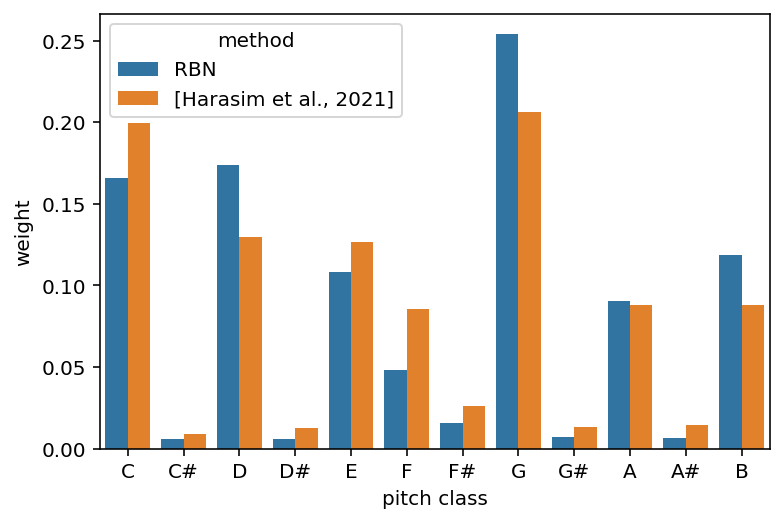

In [12]:
print(list(rbn.mixture_weights.detach().numpy().round(2)))

weights_rbn = rbn.prior_mean.exp().detach().clone().numpy()
weights_rbn /= weights_rbn.sum()
weights_bayes = KeyEstimator.profiles['bayes']['major']
pitch_classes = np.array(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
data_rbn = pd.DataFrame()
data_rbn['weight'] = weights_rbn
data_rbn['pitch class'] = pitch_classes
data_rbn['method'] = "RBN"
data_bayes = pd.DataFrame()
data_bayes['weight'] = weights_bayes
data_bayes['pitch class'] = pitch_classes
data_bayes['method'] = "[Harasim et al., 2021]"
data = pd.concat((data_rbn, data_bayes), ignore_index=True)
sns.barplot(x="pitch class", y="weight", hue="method", data=data);

This generates the plots for all 24 pieces (remove the `break`) from Table 1.

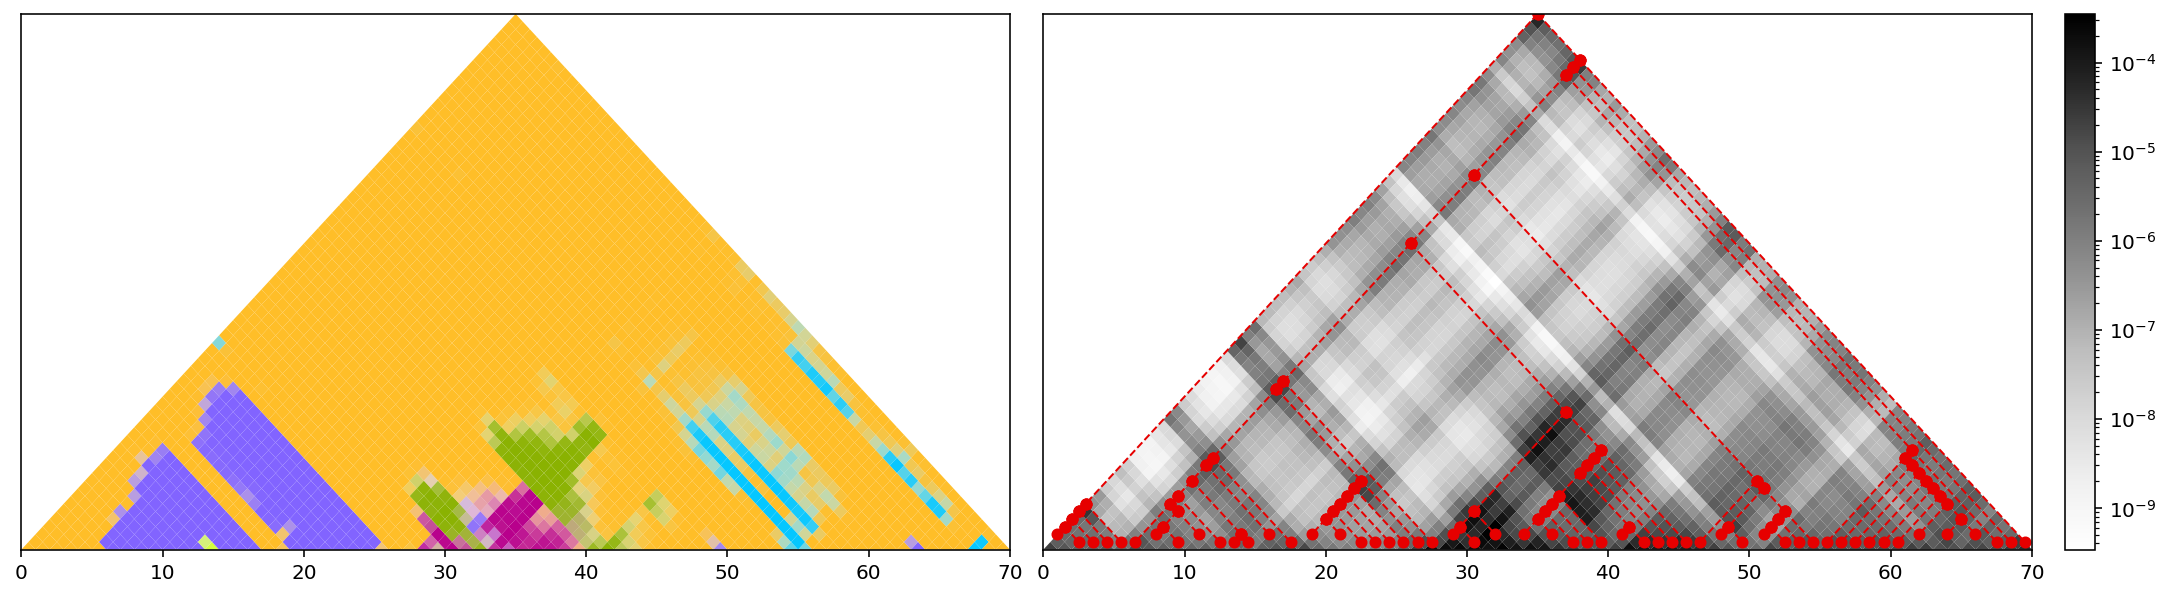

In [13]:
for batch_idx in range(rbn.n_batch):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4),
                             gridspec_kw=dict(width_ratios=[1, 1, 0.03],
                                              left=0.005, right=0.965, bottom=0.06, top=0.99,
                                              wspace=0.05))
    axes[0].set_yticks([])
    axes[1].set_yticks([])
    scape_plot_from_array(
        arr=counts_to_colors((rbn.node_mean.flatten('se')).detach().exp().numpy()[:, batch_idx]),
        ax=axes[0]
    )
    scape_plot(arr=rbn.node_log_coef.arr.exp().clone().detach().numpy()[:, batch_idx],
               ax=axes[1],
               cmap='Greys',
               colorbar=axes[2],
               log_scale=True)
    plot_model_tree(node_dict=rbn.max_tree()[0][batch_idx],
                    ax=axes[1],
                    color=(0.9, 0, 0), lw=1, ls='--')
    plt.show()
    break  # remove to plot all 24 pieces

This generates the comparison to the expert annotation from Figure 6(c)

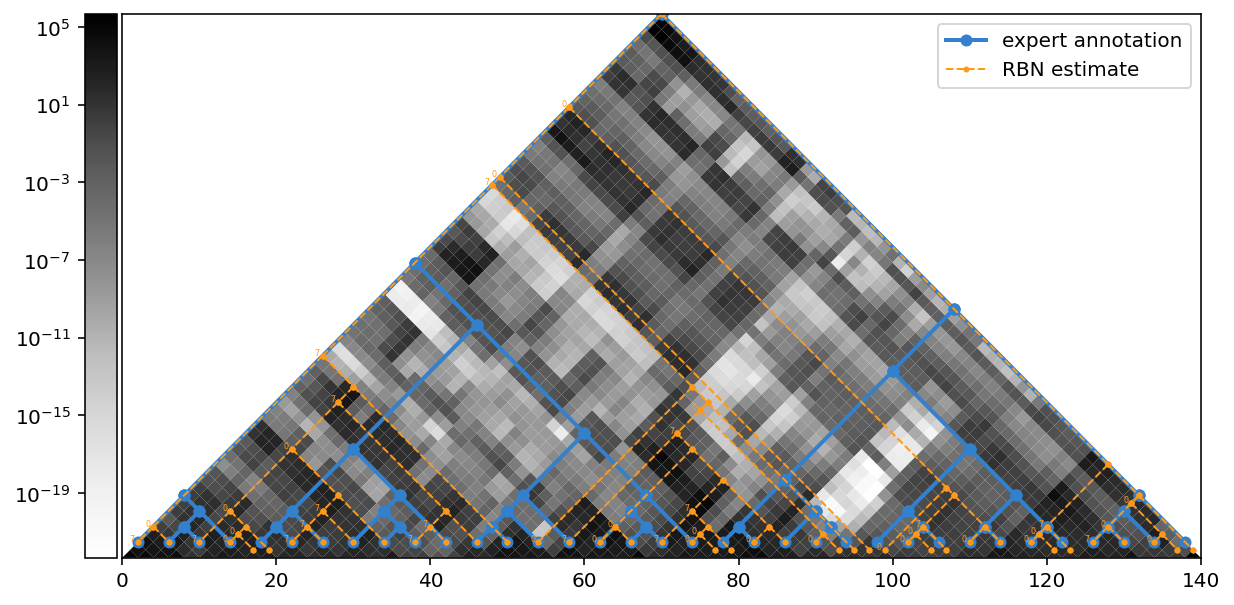

In [14]:
comparison(file='music_pretrained.pt')

The annotation (including node labels) are shown below. It can be written as

`[C [C [C [C] [C [G7/B [Dm7/C] [G7/B]] [C]]] [C [G [G/B [D7/C [Am] [D7/C]] [G/B]] [G [D7 [Cmaj7/B] [D7 [Am7] [D7]]] [G]]] [C [C/E [Bdim7/F [Dm/F [C#dim7/G] [Dm/F]] [Bdim7/F]] [C/E]] [C [G7 [Fmaj7/E] [G7 [Dm7] [G7]]] [C]]]]][C [G7 [G7 [Fmaj7 [C7] [Fmaj7]] [G7 [F#dim7] [G7 [Abdim7] [G7]]]] [G7 [G7 [Gsus64] [G7 [G7sus4] [G7]]] [G7 [Gsus64 [F#dim7/G] [Gsus64]] [G7 [G7sus4] [G7]]]] ] [C [G7/C [F/C [C7/C] [F/C]] [G7/C]] [C]] ] ]`

and also be visualised, e.g. on this webpage: http://ironcreek.net/syntaxtree/

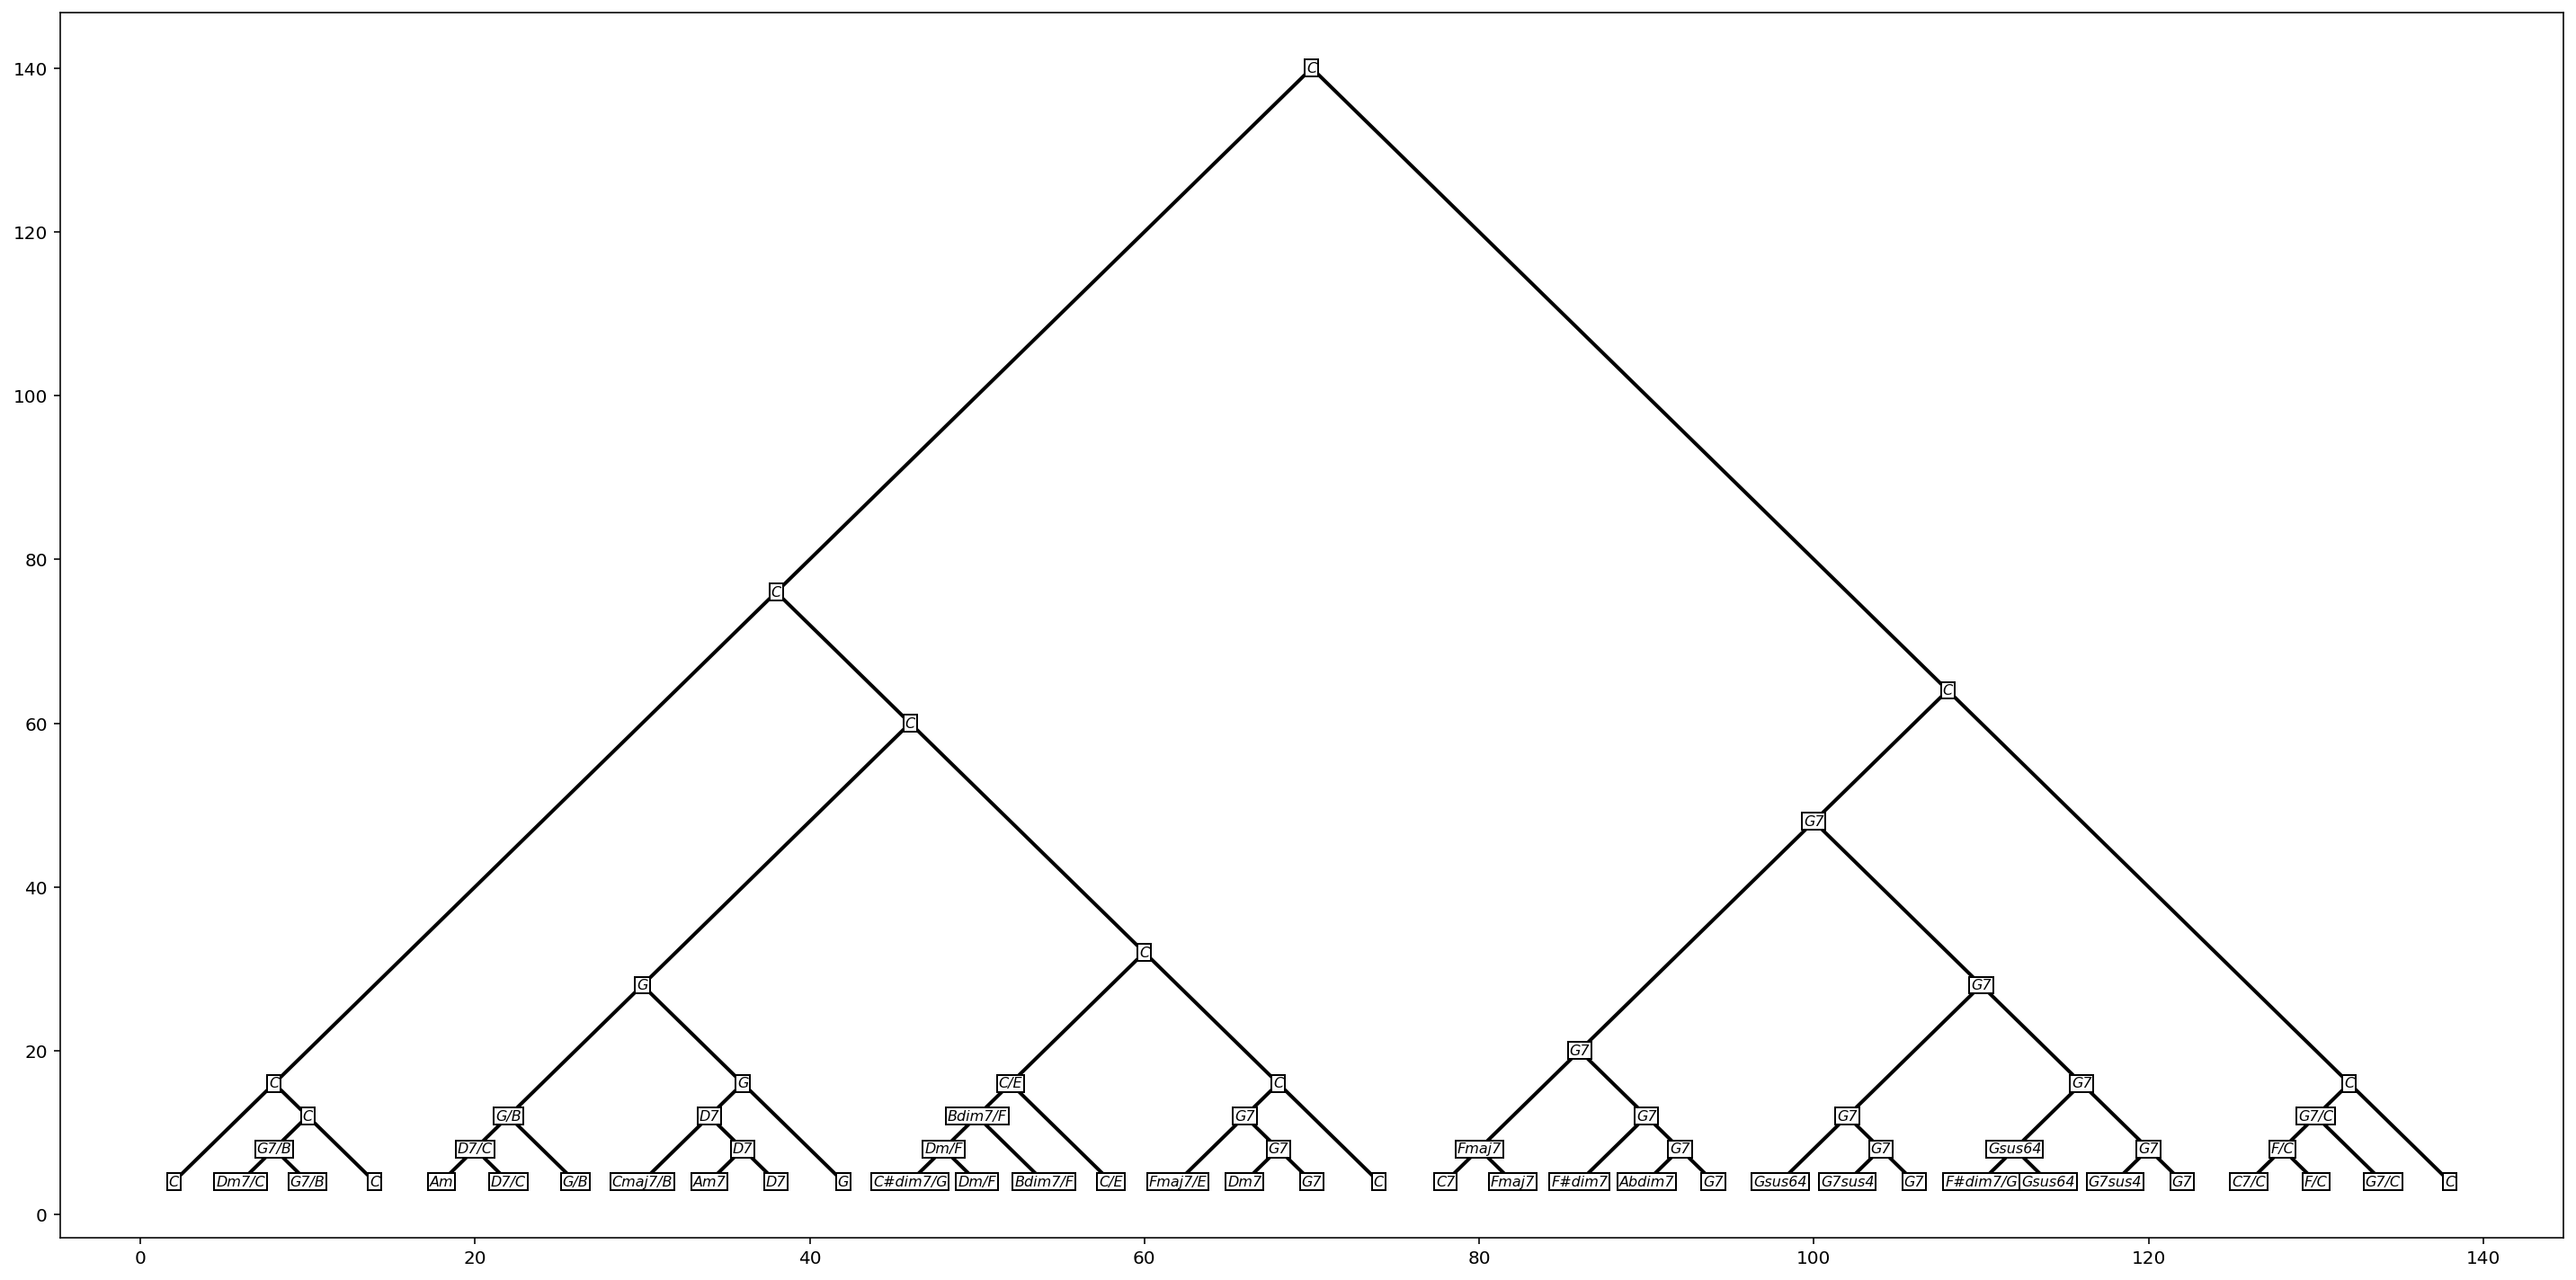

In [15]:
plot_tree();